In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import os
import shutil

from torchvision import datasets, transforms, models

from tqdm import tqdm

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)
print(torch.cuda.is_available())

cuda
True


In [4]:
transform_train = transforms.Compose([
#                                 transforms.RandomAffine(degrees = 180, translate = (0.15, 0.15)),
                                transforms.Resize((299, 299)),
                                transforms.RandomAffine(degrees = 180),
                                transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225]
#                                                     )
])

In [5]:
# 23906 dataset
# 19125 train
# 4781 validation

dataset = datasets.ImageFolder('./data', transform=transform_train)

# dataset = datasets.ImageFolder('./data')
train_set, val_set = torch.utils.data.random_split(dataset, [19125, 4781])


In [6]:
training_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = 50, shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = val_set, batch_size = 50, shuffle = False)


In [ ]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  # image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  # image = image.clip(0, 1)
  return image

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
print(images[1].shape)
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

# for inputs, labels in training_loader:
#     for i in range(20):
# #         print(labels[i])
#         plt.imshow(im_convert(inputs[i]))
#     break;

In [ ]:
model = models.inception_v3(pretrained=True, progress=True, aux_logits=False, transform_input=True)

In [ ]:
model

In [ ]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 10)),
#                                         ('relu', nn.ReLU()),
#                                         ('drop', nn.Dropout(p=0.5)),
#                                         ('fc2', nn.Linear(512, 10)),
#                                         ('output', nn.Softmax(dim=1))
                                       ]))

model.fc = classifier

In [ ]:
model

In [9]:
model = model.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=0.1, weight_decay=0.9, momentum=0.9, centered=False)

In [11]:
epochs = 30
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  for inputs, labels in tqdm(training_loader):
    inputs = inputs.to(device) #GPU
    labels = labels.to(device) #GPU
#     outputs = model(inputs)
    outputs, aux = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else: 
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device) #GPU
        val_labels = val_labels.to(device) #GPU
        val_outputs, aux = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(train_set)*100
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(val_set)*100
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch: ', (e+1))
    print('training loss: {:.4f}, {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  1
training loss: 1.6861, 77.6993 
validation loss: 1.8331, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  2
training loss: 1.8325, 77.6993 
validation loss: 1.8243, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  3
training loss: 1.8323, 77.6993 
validation loss: 1.8340, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  4
training loss: 1.8319, 77.6993 
validation loss: 1.8421, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  5
training loss: 1.8328, 77.6993 
validation loss: 1.8386, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  6
training loss: 1.8320, 77.6993 
validation loss: 1.8433, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  7
training loss: 1.8331, 77.6993 
validation loss: 1.8322, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  8
training loss: 1.8320, 77.6993 
validation loss: 1.8384, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  9
training loss: 1.8328, 77.6993 
validation loss: 1.8252, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  10
training loss: 1.8323, 77.6993 
validation loss: 1.8322, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  11
training loss: 1.8315, 77.6993 
validation loss: 1.8411, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  12
training loss: 1.8324, 77.6993 
validation loss: 1.8387, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  13
training loss: 1.8325, 77.6993 
validation loss: 1.8304, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  14
training loss: 1.8321, 77.6993 
validation loss: 1.8298, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  15
training loss: 1.8325, 77.6993 
validation loss: 1.8353, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  16
training loss: 1.8322, 77.6993 
validation loss: 1.8308, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  17
training loss: 1.8326, 77.6993 
validation loss: 1.8334, 77.5152 


  0%|          | 0/383 [00:00<?, ?it/s]

epoch:  18
training loss: 1.8326, 77.6993 
validation loss: 1.8317, 77.5152 


100%|██████████| 383/383 [26:17<00:00,  4.12s/it]


KeyboardInterrupt: 

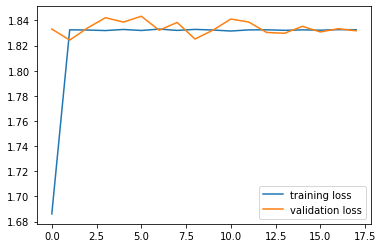

In [12]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()

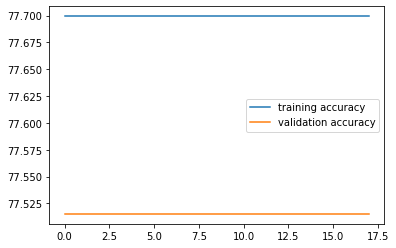

In [13]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()

In [14]:
torch.save(model, "./model/inceptionUf.pt")

In [7]:
model = torch.load("./model/inception.pt")

In [ ]:
model

In [8]:
# UnFreeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = True